In [1]:
import symnum
import symnum.numpy as snp
import simsde
import sympy
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [2]:
def drift_func(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -snp.exp(log_I + log_C) / N - snp.exp(log_I + log_C - log_S) / (2 * N),
        snp.exp(log_S + log_C) / N 
        - snp.exp(log_S + log_C - log_I) / (2 * N) 
        - (λ / 2) * snp.exp(-log_I) - λ,
        α * (β - log_C)
    ])

def diff_coeff(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), 0, 0],
        [
            -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 
            snp.sqrt(λ) * snp.exp(-log_I / 2), 
            0
        ],
        [0, 0, σ]
    ])
    

def diff_coeff_second(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 0],
        [0, snp.sqrt(λ) * snp.exp(-log_I / 2), 0],
        [0, 0, σ]
    ])
    
dim_x = 3
dim_w = 3
dim_θ = 5

v = [drift_func] + [simsde.operators.subscript_k(diff_coeff, k) for k in range(dim_x)]
x = snp.array(sympy.symbols('log_S, log_I, log_C'))
θ = snp.array(sympy.symbols('α, β, σ, λ, N'))
display(v[2](x, θ))

[-exp(log_C/2 - log_I/2 + log_S/2)/sqrt(N), sqrt(λ)*exp(-log_I/2), 0]

Text(0.5, 0, 'Time')

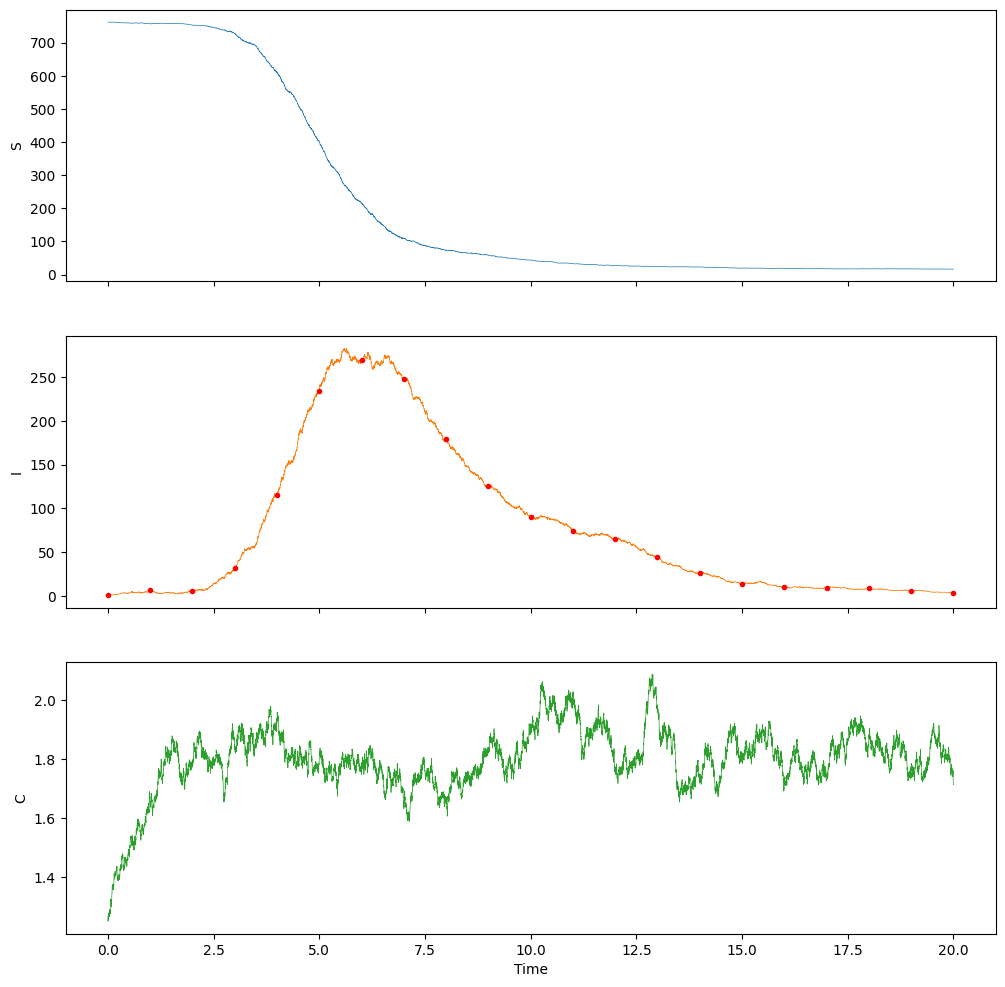

In [3]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763.,  # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])
    
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff, diff_coeff_second),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.001 
t_max = 13.
dt_observation = 1.
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

#simulation_method = "weak_order_2"
simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
#obs_noise_std = 10.
obs_noise_std = 0.4
x_0_obs = np.log(np.array([762., 1., 1.25]))
#θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
θ_obs = np.array([2.04, 0.592, 0.10, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)
y_obs = np.array([3, 8, 28, 75, 221, 281, 255, 235, 190, 125, 70, 28, 12, 5])

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, np.exp(x_seq_obs[:, i]), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[1].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.2


Sampling stage: Adaptive warm up [03:02] > Main non-adaptive [05:02]

Chain 1/4: 100%|██████████|1000/1000 [01:39<00:00, 10.02it/s, n_step=1.01e+03, accept_stat=0.917]

Chain 2/4: 100%|██████████|1000/1000 [01:39<00:00, 10.03it/s, n_step=1.01e+03, accept_stat=0.922]

Chain 3/4: 100%|██████████|1000/1000 [01:40<00:00, 9.98it/s, n_step=1.01e+03, accept_stat=0.927]

Chain 4/4: 100%|██████████|1000/1000 [00:02<00:00, 415.48it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.075,1.300,0.040,3.423,0.179,0.127,105.0,1093.0,1.24
β,0.354,0.310,-0.317,0.644,0.057,0.040,12.0,1424.0,1.24
σ,0.079,0.108,0.002,0.270,0.020,0.014,9.0,858.0,1.42
λ,0.459,0.070,0.344,0.532,0.033,0.025,7.0,4.0,1.53
x_0_2,0.194,0.835,-0.943,1.647,0.257,0.187,14.0,1710.0,1.21


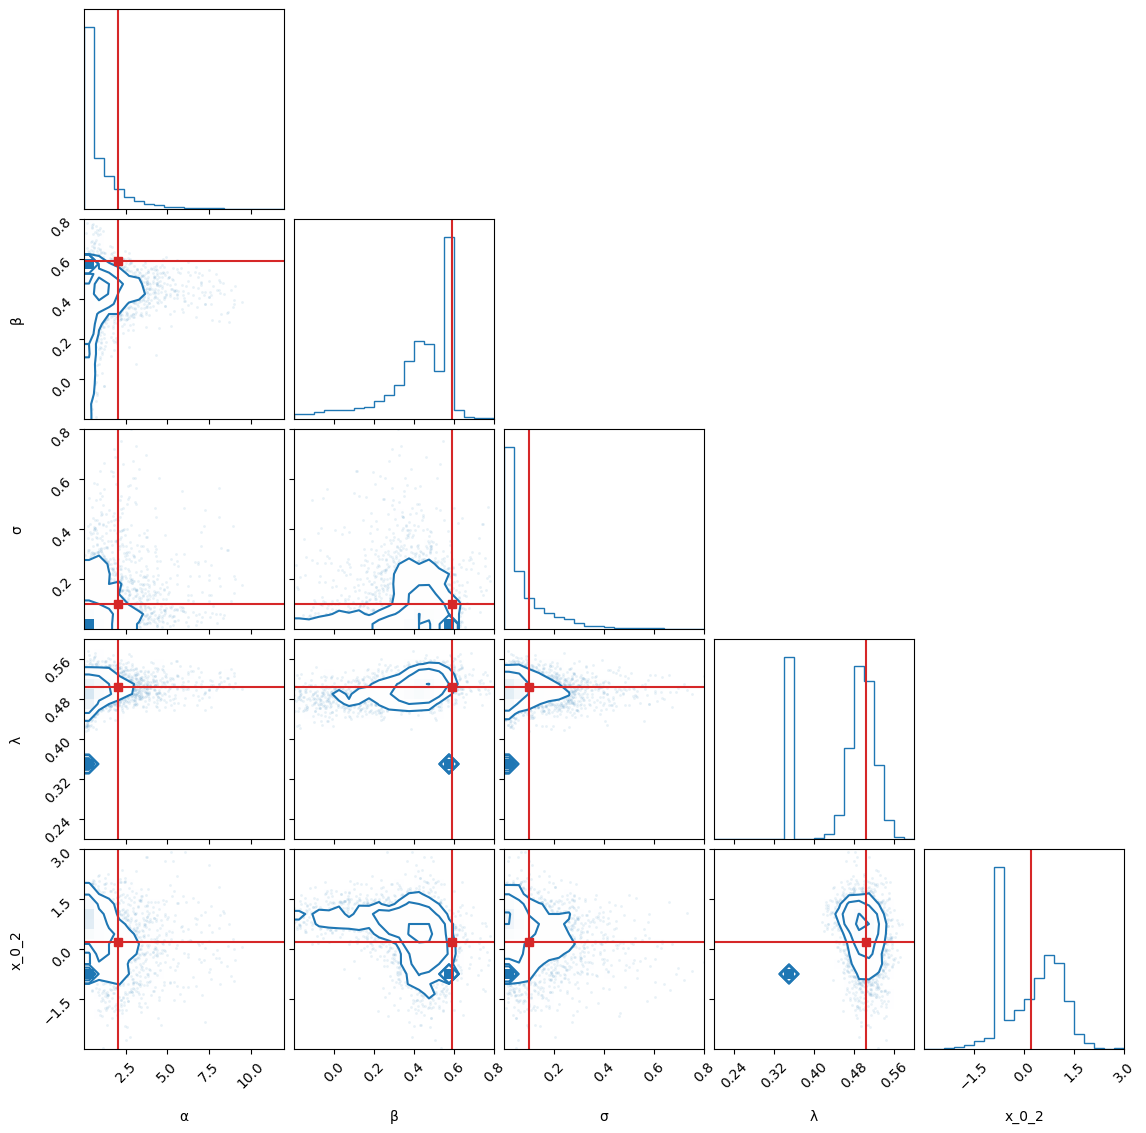

weak_order_2
0.2


Sampling stage: Adaptive warm up [03:59] > Main non-adaptive [08:59]

Chain 1/4: 100%|██████████|1000/1000 [02:15<00:00, 7.38it/s, n_step=1.00e+03, accept_stat=0.905]

Chain 2/4: 100%|██████████|1000/1000 [02:13<00:00, 7.49it/s, n_step=988., accept_stat=0.887]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [02:15<00:00, 7.35it/s, n_step=1.01e+03, accept_stat=0.923]

Chain 4/4: 100%|██████████|1000/1000 [02:14<00:00, 7.43it/s, n_step=996., accept_stat=0.898]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.789,1.604,0.033,4.815,0.036,0.025,1497.0,1603.0,1.0
β,0.493,0.180,0.174,0.725,0.005,0.004,1995.0,1251.0,1.0
σ,0.095,0.106,0.002,0.281,0.002,0.002,1588.0,1831.0,1.0
λ,0.472,0.020,0.433,0.510,0.000,0.000,3227.0,3025.0,1.0
x_0_2,0.175,0.775,-1.389,1.442,0.018,0.013,1917.0,2542.0,1.0


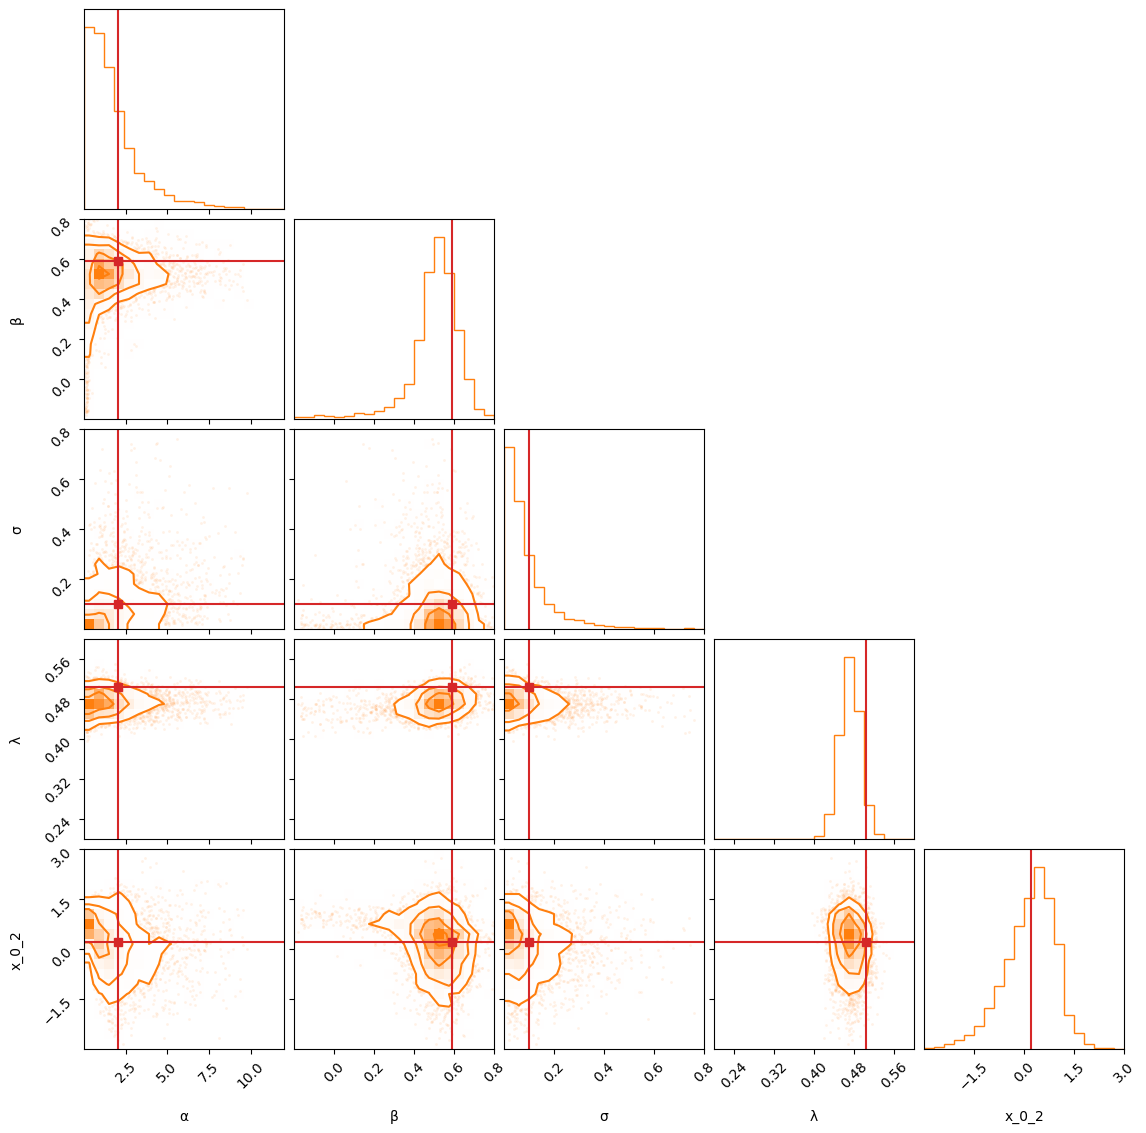

euler_maruyama
0.16


Sampling stage: Adaptive warm up [03:08] > Main non-adaptive [06:50]

Chain 1/4: 100%|██████████|1000/1000 [01:42<00:00, 9.76it/s, n_step=989., accept_stat=0.817]

Chain 2/4: 100%|██████████|1000/1000 [01:42<00:00, 9.72it/s, n_step=992., accept_stat=0.829]

Chain 3/4: 100%|██████████|1000/1000 [01:42<00:00, 9.72it/s, n_step=991., accept_stat=0.847]

Chain 4/4: 100%|██████████|1000/1000 [01:42<00:00, 9.73it/s, n_step=989., accept_stat=0.831]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.412,1.604,0.032,4.269,0.040,0.028,1008.0,1119.0,1.0
β,0.355,0.329,-0.289,0.713,0.012,0.008,1245.0,1104.0,1.0
σ,0.109,0.132,0.001,0.331,0.003,0.002,1320.0,2338.0,1.0
λ,0.515,0.024,0.472,0.561,0.000,0.000,2927.0,2080.0,1.0
x_0_2,0.447,0.751,-1.080,1.604,0.019,0.014,1438.0,2700.0,1.0


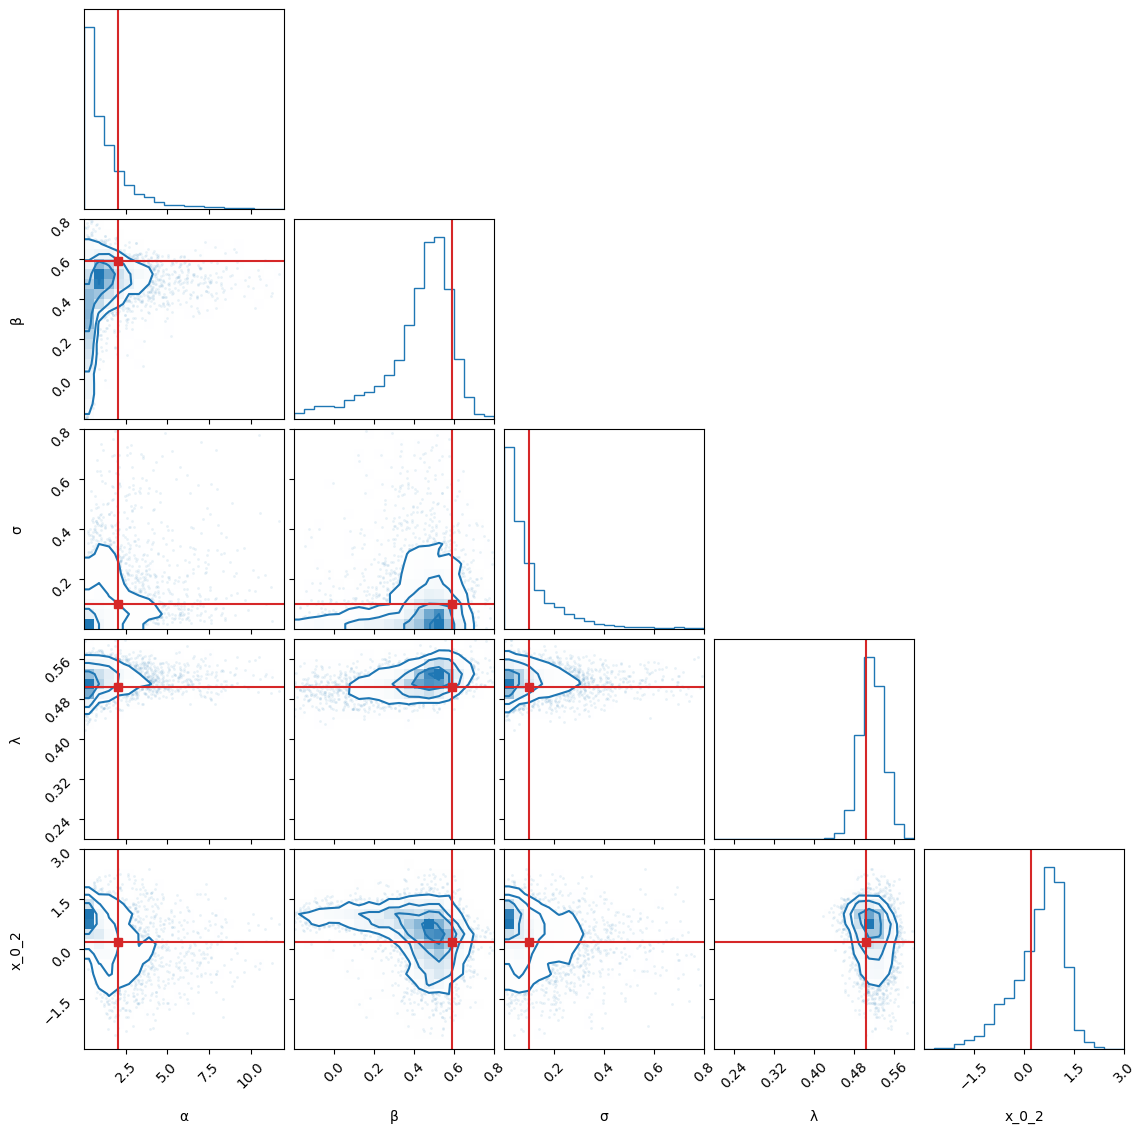

weak_order_2
0.16


Sampling stage: Adaptive warm up [04:32] > Main non-adaptive [07:17]

Chain 1/4: 100%|██████████|1000/1000 [02:25<00:00, 6.89it/s, n_step=969., accept_stat=0.864]

Chain 2/4: 100%|██████████|1000/1000 [02:25<00:00, 6.86it/s, n_step=973., accept_stat=0.869]

Chain 3/4: 100%|██████████|1000/1000 [00:02<00:00, 407.54it/s, n_step=1.00, accept_stat=0.00]

Chain 4/4: 100%|██████████|1000/1000 [02:24<00:00, 6.93it/s, n_step=963., accept_stat=0.851]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.392,1.651,0.020,4.163,0.264,0.188,32.0,788.0,1.10
β,0.424,0.240,0.171,0.755,0.074,0.057,12.0,5.0,1.25
σ,0.097,0.104,0.003,0.246,0.004,0.003,409.0,1108.0,1.27
λ,0.541,0.090,0.461,0.694,0.044,0.034,7.0,1331.0,1.53
x_0_2,0.326,0.684,-1.144,1.426,0.023,0.034,1069.0,1762.0,1.53


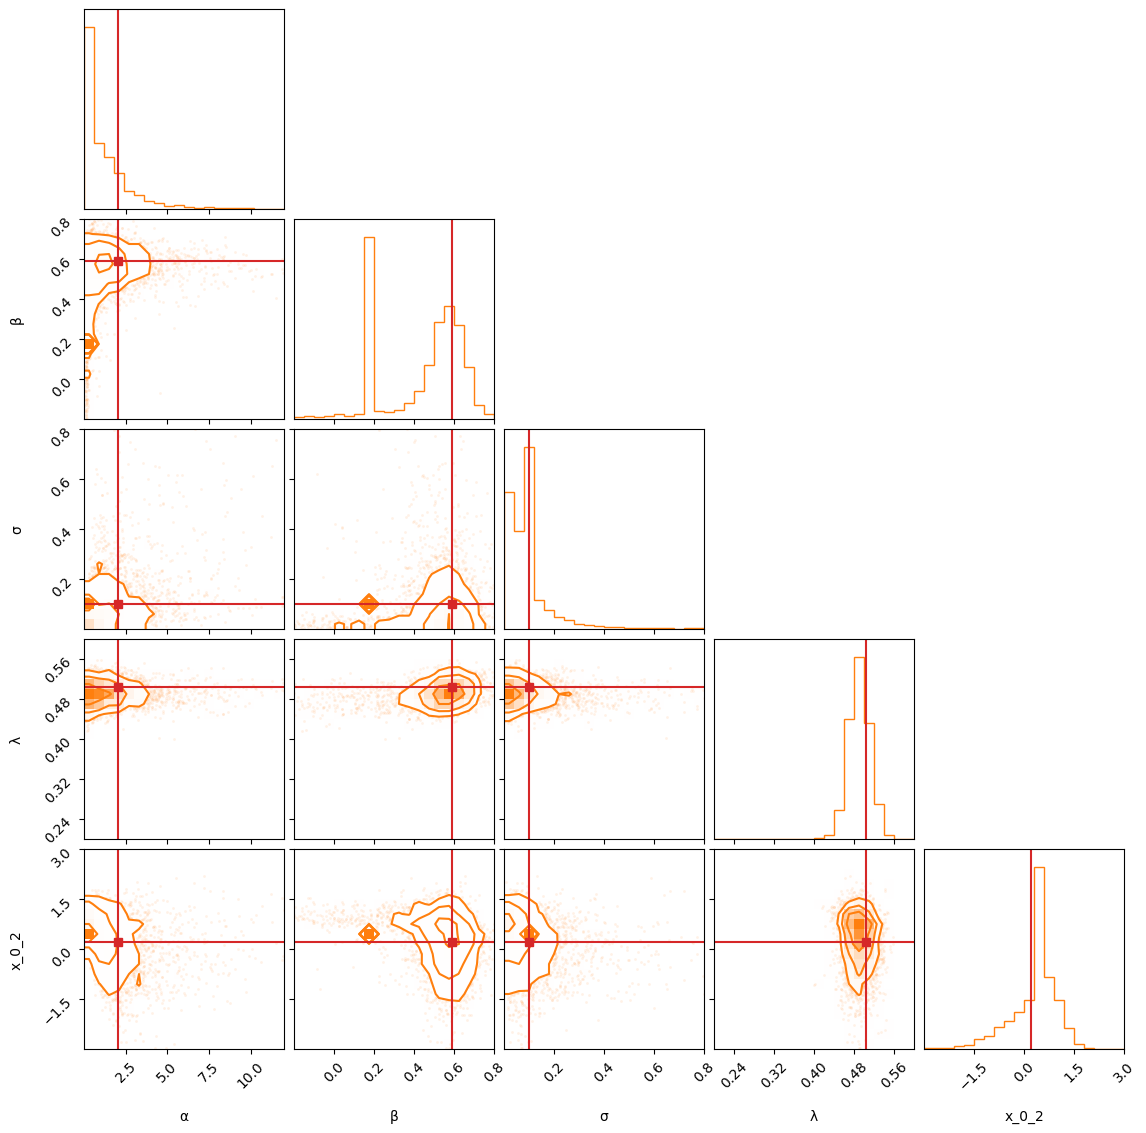

euler_maruyama
0.12


Sampling stage: Adaptive warm up [03:19] > Main non-adaptive [07:22]

Chain 1/4: 100%|██████████|1000/1000 [01:50<00:00, 9.07it/s, n_step=997., accept_stat=0.855]

Chain 2/4: 100%|██████████|1000/1000 [01:51<00:00, 9.00it/s, n_step=1.01e+03, accept_stat=0.882]

Chain 3/4: 100%|██████████|1000/1000 [01:50<00:00, 9.08it/s, n_step=995., accept_stat=0.857]

Chain 4/4: 100%|██████████|1000/1000 [01:51<00:00, 9.01it/s, n_step=1.00e+03, accept_stat=0.890]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.525,1.776,0.021,4.580,0.043,0.030,999.0,2007.0,1.0
β,0.407,0.274,-0.170,0.750,0.007,0.005,1445.0,2026.0,1.0
σ,0.096,0.113,0.002,0.284,0.003,0.002,1210.0,1777.0,1.0
λ,0.510,0.022,0.466,0.551,0.000,0.000,3124.0,3059.0,1.0
x_0_2,0.400,0.779,-1.182,1.576,0.020,0.014,1497.0,2478.0,1.0


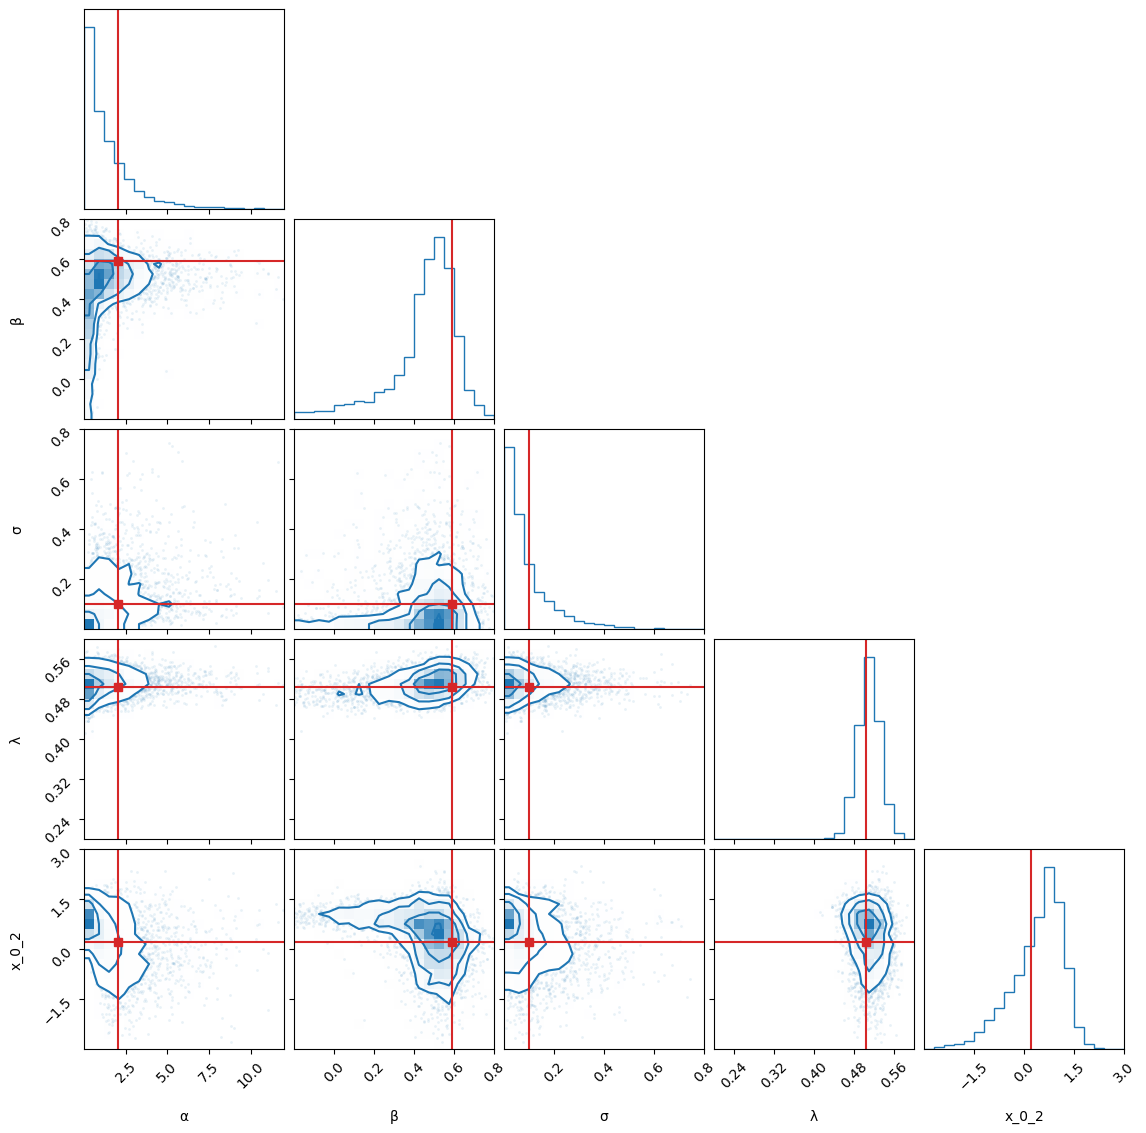

weak_order_2
0.12


Sampling stage: Adaptive warm up [05:08] > Main non-adaptive [05:05]

Chain 1/4: 100%|██████████|1000/1000 [01:23<00:00, 11.95it/s, n_step=489., accept_stat=0.470]

Chain 2/4: 100%|██████████|1000/1000 [02:50<00:00, 5.88it/s, n_step=1.01e+03, accept_stat=0.975]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [00:03<00:00, 292.63it/s, n_step=6.56, accept_stat=0.00]

Chain 4/4: 100%|██████████|1000/1000 [00:48<00:00, 20.55it/s, n_step=279., accept_stat=0.261]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.507,1.419,0.033,3.699,0.170,0.121,43.0,81.0,1.28
β,0.590,0.198,0.404,0.894,0.075,0.067,5.0,11.0,2.00
σ,0.092,0.096,0.006,0.212,0.029,0.021,10.0,69.0,1.43
λ,0.495,0.023,0.466,0.542,0.008,0.006,10.0,25.0,1.53
x_0_2,0.025,0.676,-0.995,1.425,0.188,0.136,14.0,95.0,1.38


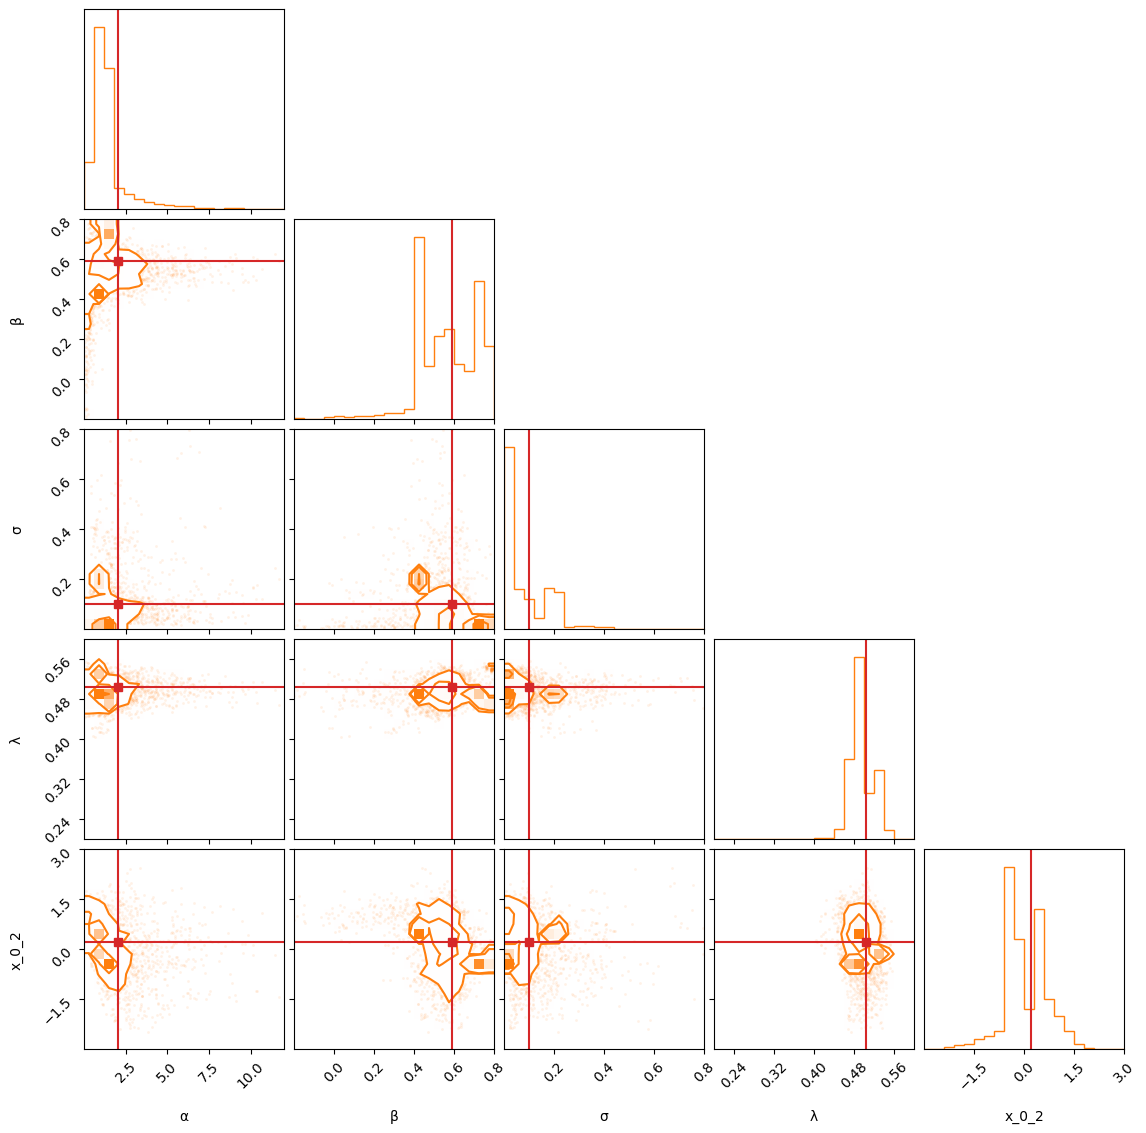

euler_maruyama
0.1


Sampling stage: Adaptive warm up [03:26] > Main non-adaptive [07:21]

Chain 1/4: 100%|██████████|1000/1000 [01:55<00:00, 8.68it/s, n_step=995., accept_stat=0.826]

Chain 2/4: 100%|██████████|1000/1000 [01:56<00:00, 8.61it/s, n_step=1.00e+03, accept_stat=0.840]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [01:34<00:00, 10.58it/s, n_step=813., accept_stat=0.682]

Chain 4/4: 100%|██████████|1000/1000 [01:55<00:00, 8.65it/s, n_step=999., accept_stat=0.835]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.542,1.849,0.029,4.617,0.061,0.043,127.0,576.0,1.03
β,0.363,0.311,-0.480,0.649,0.053,0.037,90.0,28.0,1.03
σ,0.094,0.106,0.002,0.281,0.003,0.002,549.0,2061.0,1.01
λ,0.486,0.021,0.445,0.525,0.001,0.001,810.0,2247.0,1.01
x_0_2,0.369,0.776,-1.183,1.584,0.041,0.029,209.0,2325.0,1.02


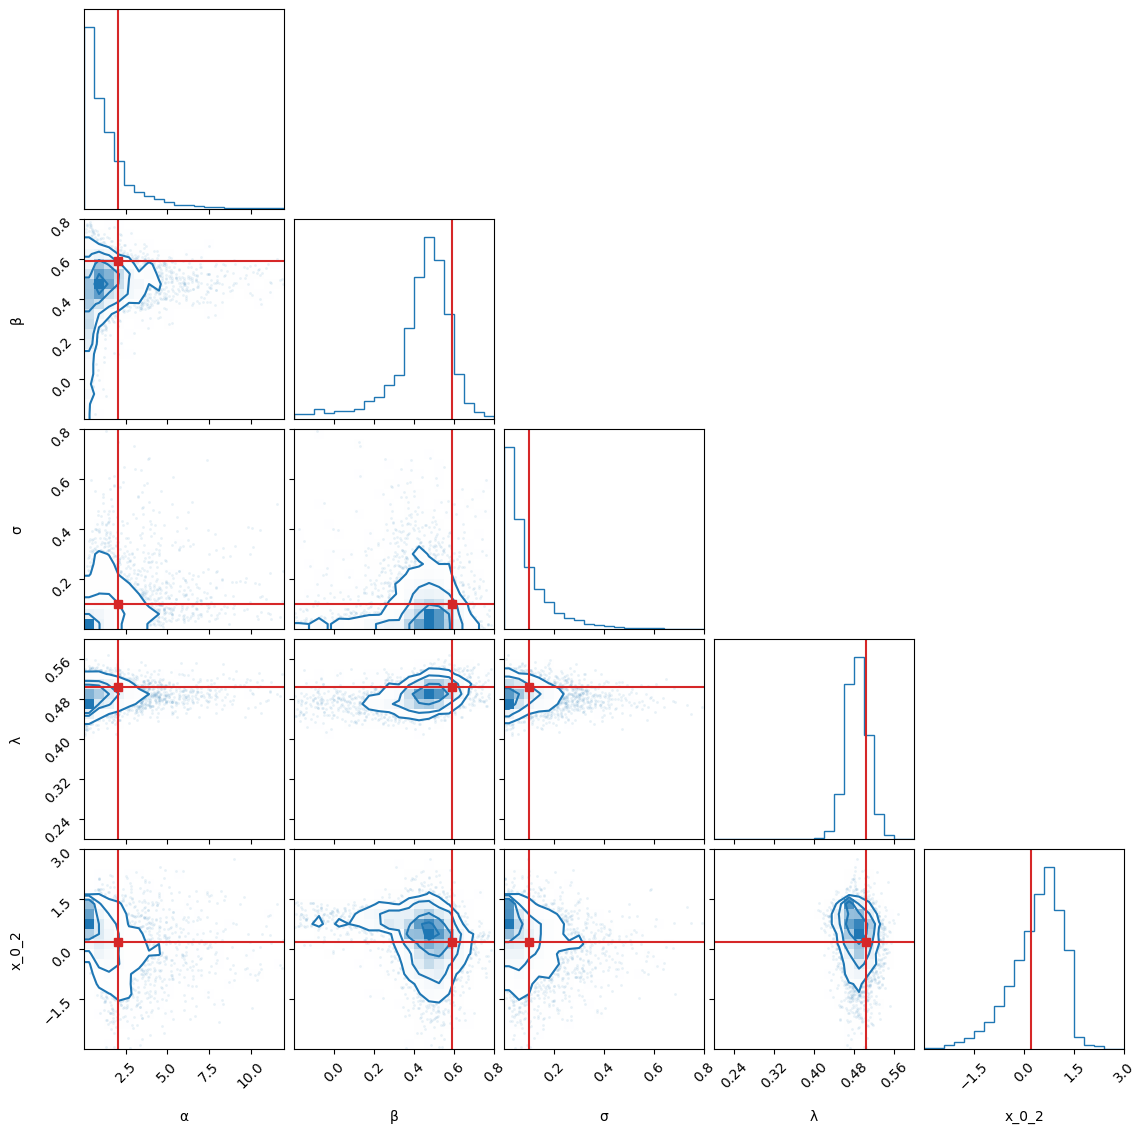

weak_order_2
0.1


Sampling stage: Adaptive warm up [05:33] > Main non-adaptive [11:16]

Chain 1/4: 100%|██████████|1000/1000 [03:06<00:00, 5.37it/s, n_step=994., accept_stat=0.894]

Chain 2/4: 100%|██████████|1000/1000 [01:57<00:00, 8.49it/s, n_step=624., accept_stat=0.561]

Chain 3/4: 100%|██████████|1000/1000 [03:07<00:00, 5.34it/s, n_step=999., accept_stat=0.896]

Chain 4/4: 100%|██████████|1000/1000 [03:05<00:00, 5.39it/s, n_step=988., accept_stat=0.897]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.834,1.901,0.028,5.069,0.042,0.030,1258.0,1665.0,1.10
β,0.485,0.180,0.170,0.753,0.004,0.003,1944.0,1432.0,1.09
σ,0.142,0.179,0.004,0.579,0.060,0.044,19.0,16.0,1.15
λ,0.473,0.020,0.437,0.511,0.001,0.001,466.0,2876.0,1.02
x_0_2,0.270,0.758,-1.363,1.362,0.053,0.038,222.0,2047.0,1.02


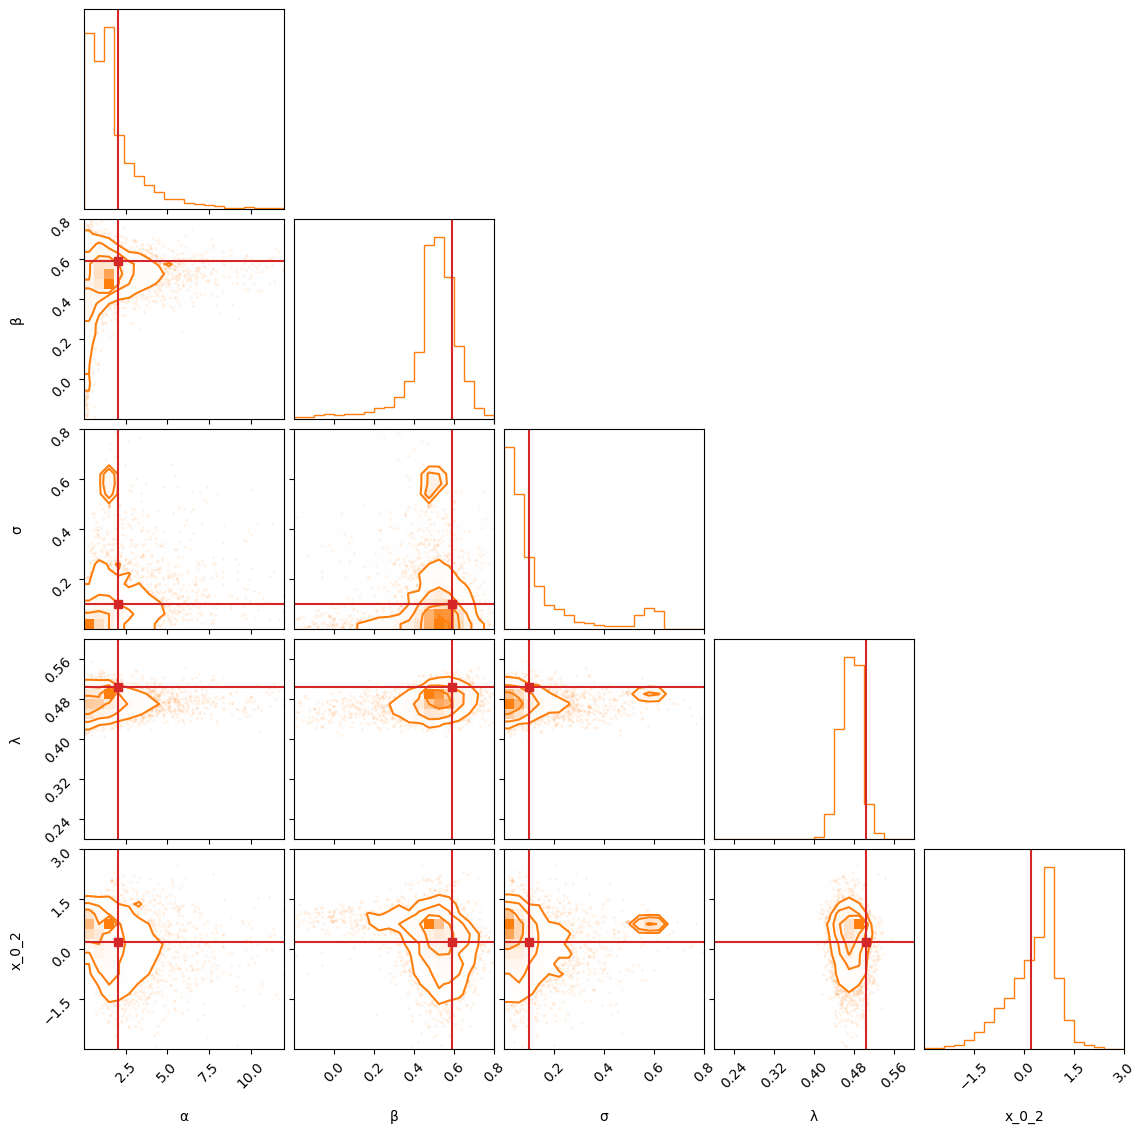

euler_maruyama
0.08


Sampling stage: Adaptive warm up [03:37] > Main non-adaptive [08:06]

Chain 1/4: 100%|██████████|1000/1000 [02:00<00:00, 8.29it/s, n_step=987., accept_stat=0.825]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:02<00:00, 8.14it/s, n_step=1.01e+03, accept_stat=0.864]

Chain 3/4: 100%|██████████|1000/1000 [02:02<00:00, 8.17it/s, n_step=1.00e+03, accept_stat=0.834]

Chain 4/4: 100%|██████████|1000/1000 [02:01<00:00, 8.26it/s, n_step=991., accept_stat=0.825]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.800,2.200,0.030,5.188,0.050,0.036,1385.0,1431.0,1.0
β,0.454,0.240,0.001,0.748,0.007,0.005,1869.0,1673.0,1.0
σ,0.103,0.127,0.002,0.305,0.003,0.002,2288.0,2059.0,1.0
λ,0.504,0.023,0.462,0.546,0.000,0.000,3725.0,2253.0,1.0
x_0_2,0.318,0.789,-1.287,1.593,0.015,0.012,2431.0,1897.0,1.0


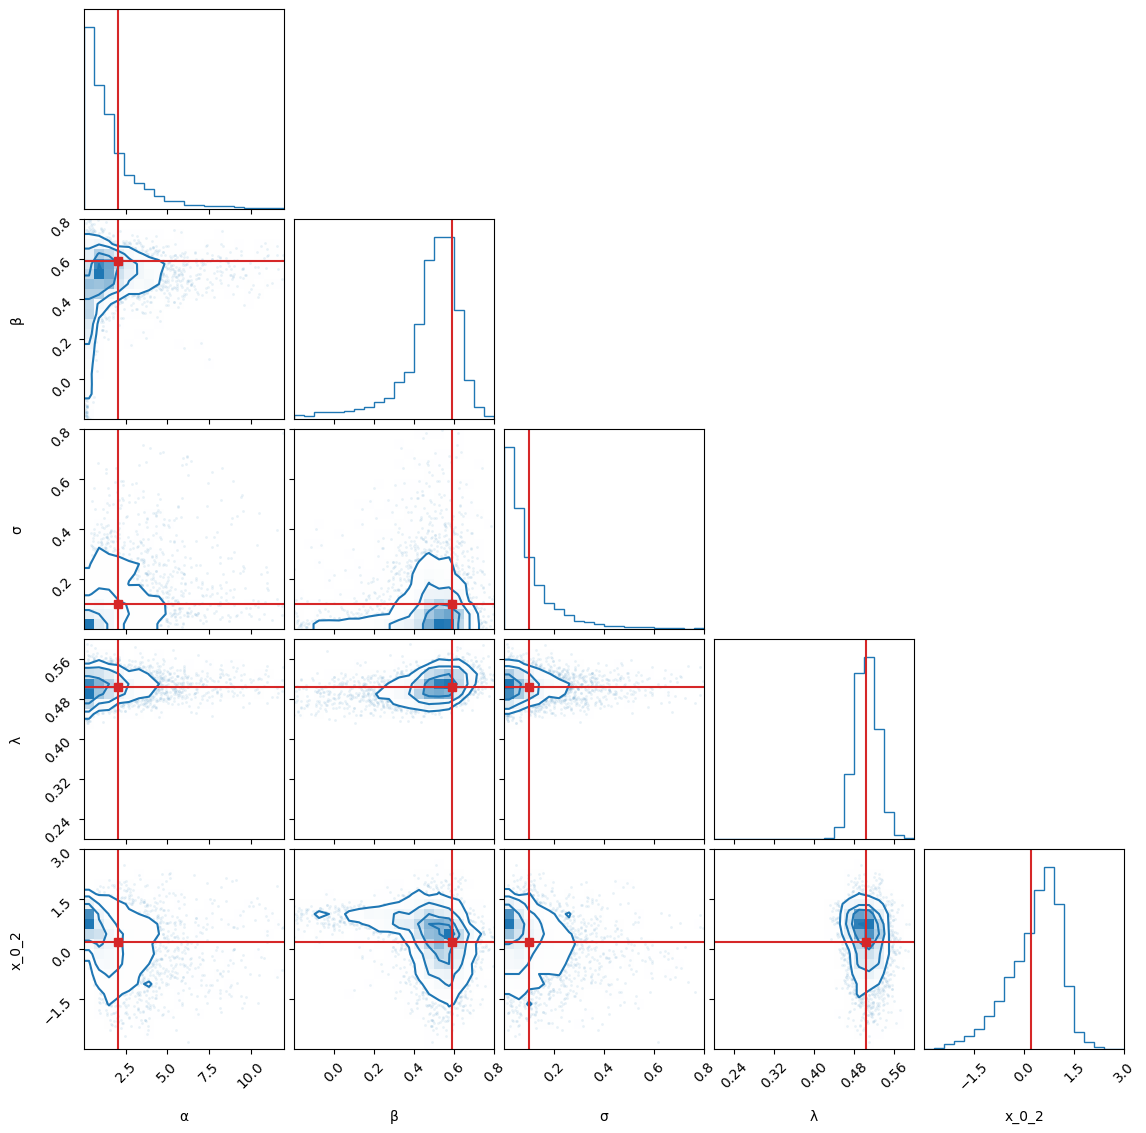

weak_order_2
0.08


Sampling stage: Adaptive warm up [06:18] > Main non-adaptive [12:52]

Chain 1/4: 100%|██████████|1000/1000 [03:13<00:00, 5.16it/s, n_step=925., accept_stat=0.848]

Chain 2/4: 100%|██████████|1000/1000 [03:17<00:00, 5.05it/s, n_step=945., accept_stat=0.876]

Chain 3/4: 100%|██████████|1000/1000 [03:03<00:00, 5.45it/s, n_step=875., accept_stat=0.808]

Chain 4/4: 100%|██████████|1000/1000 [03:17<00:00, 5.08it/s, n_step=941., accept_stat=0.866]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.880,1.990,0.032,5.235,0.081,0.057,394.0,515.0,1.01
β,0.522,0.224,0.136,0.782,0.010,0.007,465.0,599.0,1.02
σ,0.093,0.102,0.001,0.268,0.004,0.003,407.0,804.0,1.01
λ,0.493,0.021,0.454,0.532,0.001,0.001,323.0,952.0,1.01
x_0_2,0.249,0.792,-1.261,1.623,0.037,0.026,378.0,478.0,1.02


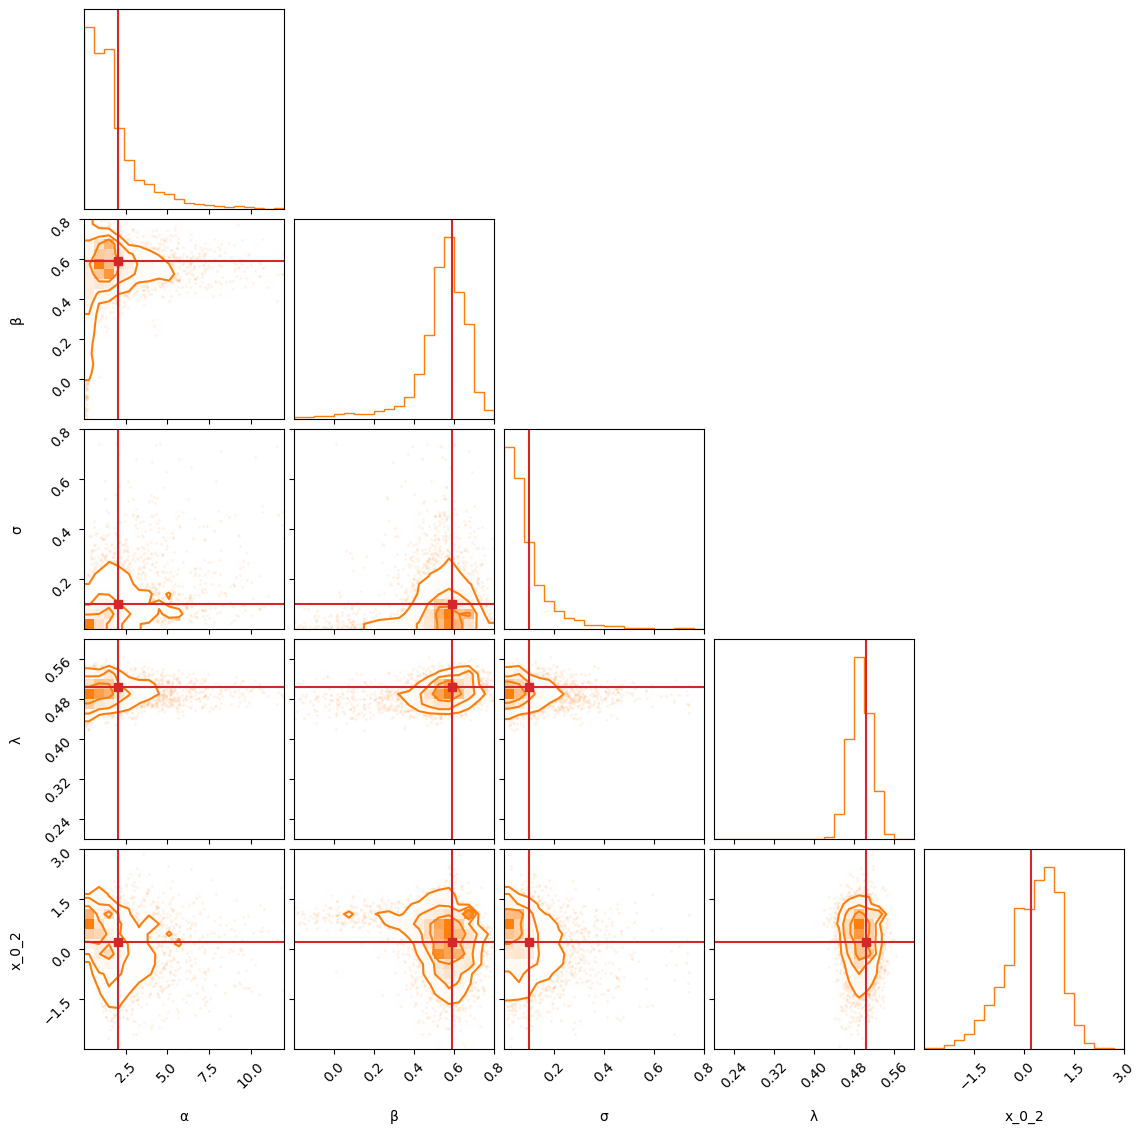

euler_maruyama
0.06


Sampling stage: Adaptive warm up [04:00] > Main non-adaptive [08:55]

Chain 1/4: 100%|██████████|1000/1000 [02:12<00:00, 7.54it/s, n_step=979., accept_stat=0.795]

Chain 2/4: 100%|██████████|1000/1000 [02:13<00:00, 7.50it/s, n_step=986., accept_stat=0.804]

Chain 3/4: 100%|██████████|1000/1000 [02:14<00:00, 7.43it/s, n_step=994., accept_stat=0.842]

Chain 4/4: 100%|██████████|1000/1000 [02:14<00:00, 7.43it/s, n_step=995., accept_stat=0.840]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.785,2.264,0.033,5.417,0.045,0.032,1465.0,1939.0,1.00
β,0.462,0.234,-0.047,0.799,0.008,0.006,1636.0,512.0,1.00
σ,0.098,0.117,0.002,0.287,0.002,0.002,1587.0,2188.0,1.01
λ,0.500,0.022,0.462,0.544,0.000,0.000,3754.0,2496.0,1.00
x_0_2,0.327,0.771,-1.247,1.536,0.016,0.011,2154.0,1634.0,1.00


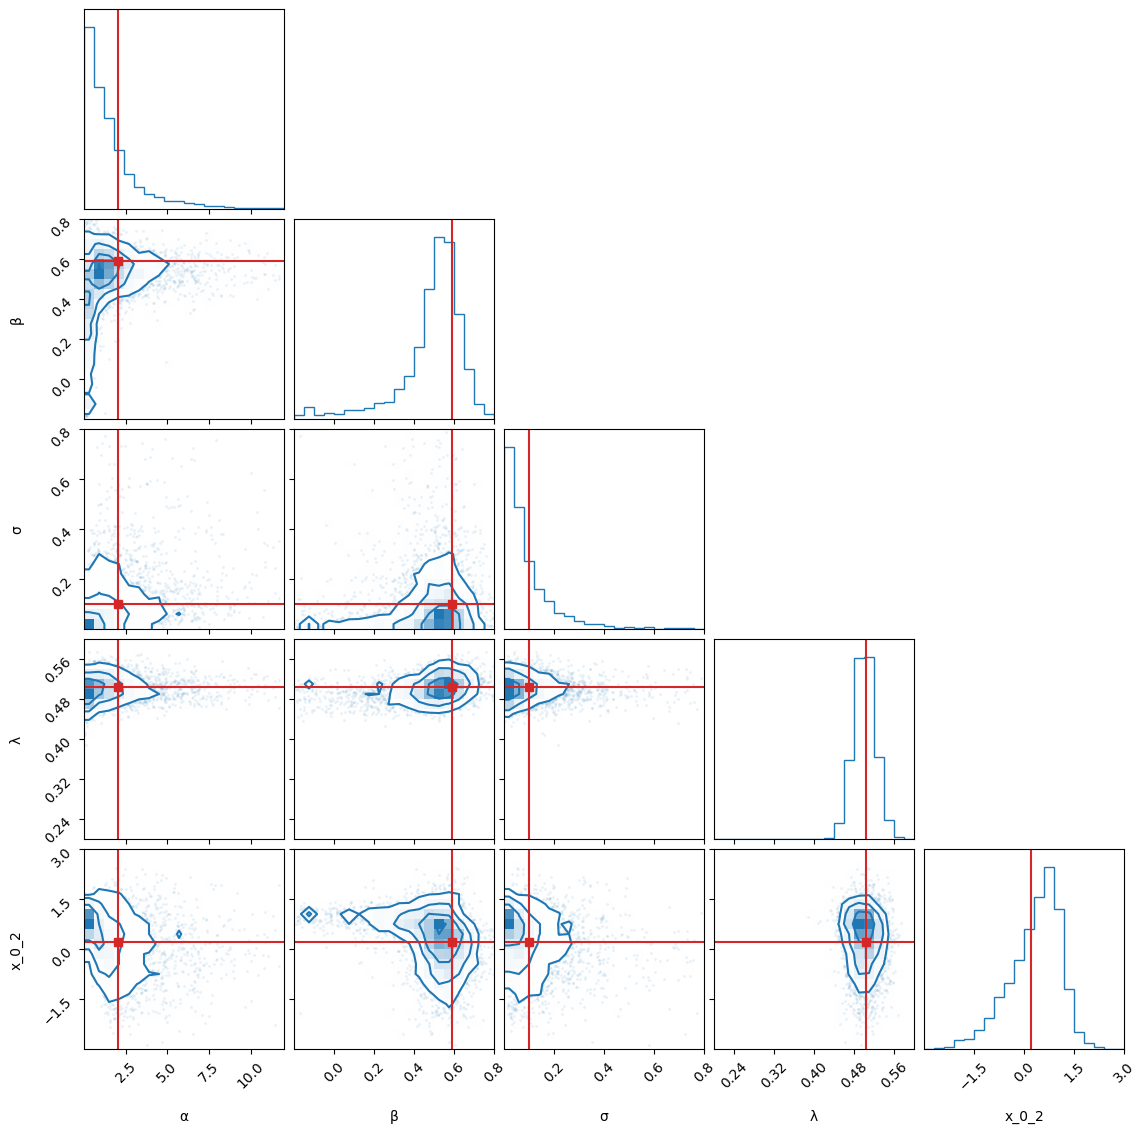

weak_order_2
0.06


Sampling stage: Adaptive warm up [07:52] > Main non-adaptive [16:36]

Chain 1/4: 100%|██████████|1000/1000 [04:09<00:00, 4.00it/s, n_step=967., accept_stat=0.859]

Chain 2/4: 100%|██████████|1000/1000 [04:06<00:00, 4.06it/s, n_step=951., accept_stat=0.832]

Chain 3/4: 100%|██████████|1000/1000 [04:09<00:00, 4.00it/s, n_step=966., accept_stat=0.846]

Chain 4/4: 100%|██████████|1000/1000 [04:10<00:00, 3.99it/s, n_step=969., accept_stat=0.865]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.902,2.189,0.025,5.292,0.059,0.042,820.0,1202.0,1.0
β,0.516,0.214,0.175,0.796,0.008,0.006,1136.0,1265.0,1.0
σ,0.097,0.115,0.001,0.277,0.003,0.002,1022.0,1936.0,1.0
λ,0.491,0.021,0.452,0.528,0.000,0.000,1934.0,2087.0,1.0
x_0_2,0.271,0.806,-1.462,1.503,0.026,0.018,972.0,1320.0,1.0


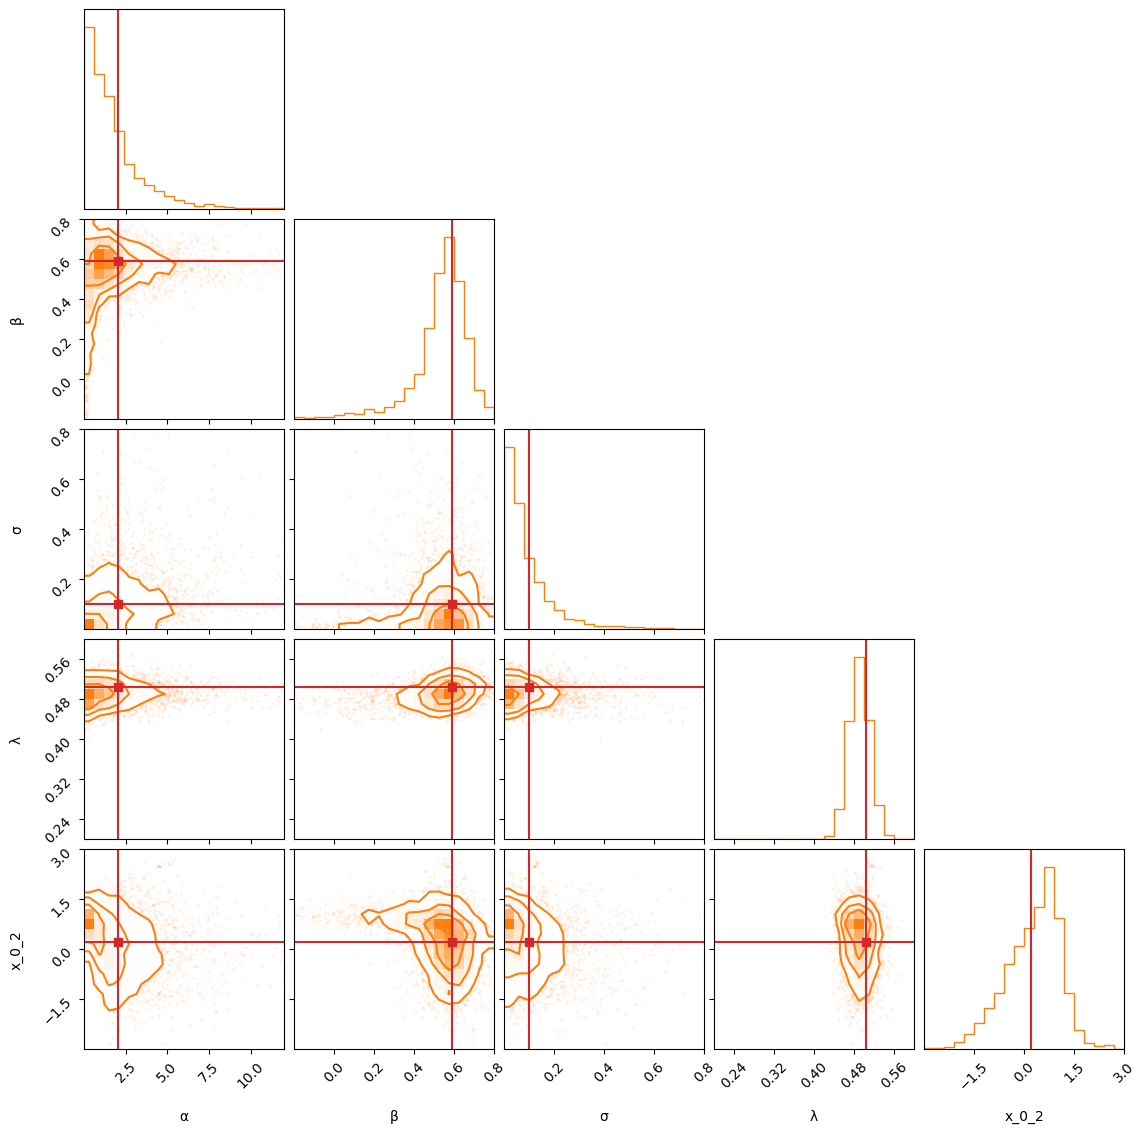

euler_maruyama
0.05


Sampling stage: Adaptive warm up [04:18] > Main non-adaptive [09:36]

Chain 1/4: 100%|██████████|1000/1000 [02:24<00:00, 6.90it/s, n_step=998., accept_stat=0.838]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:24<00:00, 6.92it/s, n_step=995., accept_stat=0.838]

Chain 3/4: 100%|██████████|1000/1000 [02:23<00:00, 6.95it/s, n_step=994., accept_stat=0.834]

Chain 4/4: 100%|██████████|1000/1000 [02:23<00:00, 6.97it/s, n_step=990., accept_stat=0.821]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.802,2.200,0.033,5.176,0.042,0.030,1829.0,2244.0,1.0
β,0.444,0.211,-0.007,0.710,0.006,0.004,1980.0,1169.0,1.0
σ,0.097,0.112,0.002,0.283,0.002,0.002,1966.0,1536.0,1.0
λ,0.480,0.020,0.443,0.517,0.000,0.000,3821.0,3039.0,1.0
x_0_2,0.275,0.783,-1.366,1.472,0.015,0.012,2587.0,2754.0,1.0


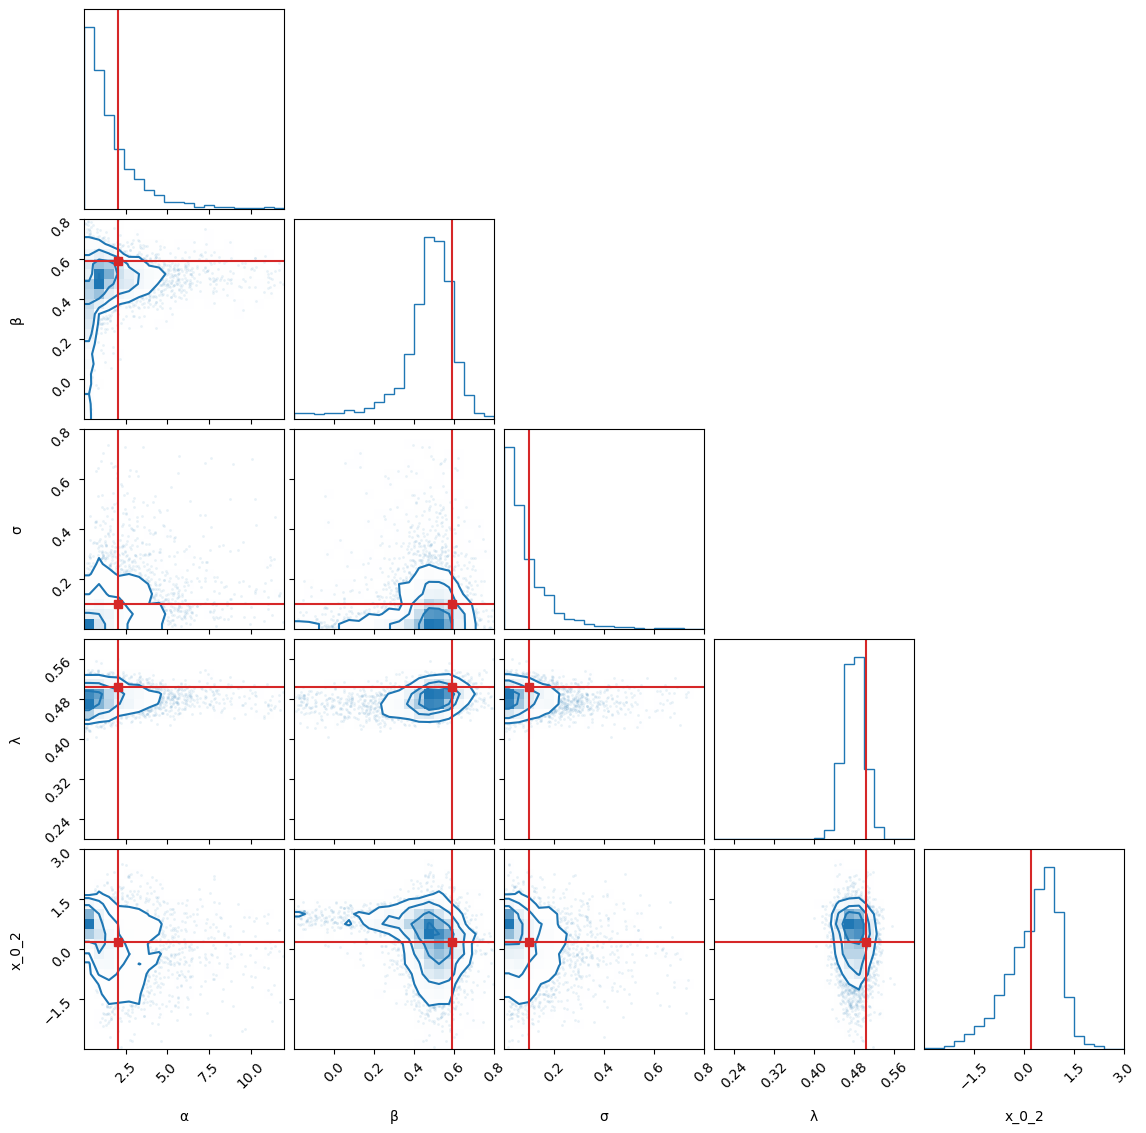

weak_order_2
0.05


Sampling stage: Adaptive warm up [08:54] > Main non-adaptive [19:21]

Chain 1/4: 100%|██████████|1000/1000 [04:56<00:00, 3.37it/s, n_step=999., accept_stat=0.912]

Chain 2/4: 100%|██████████|1000/1000 [04:53<00:00, 3.41it/s, n_step=989., accept_stat=0.890]

Chain 3/4: 100%|██████████|1000/1000 [04:53<00:00, 3.41it/s, n_step=988., accept_stat=0.892]

Chain 4/4: 100%|██████████|1000/1000 [04:37<00:00, 3.60it/s, n_step=935., accept_stat=0.838]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.898,2.324,0.017,5.141,0.054,0.038,1099.0,1171.0,1.01
β,0.483,0.189,0.170,0.749,0.005,0.004,1796.0,1510.0,1.00
σ,0.095,0.111,0.003,0.269,0.003,0.002,1372.0,1871.0,1.00
λ,0.472,0.020,0.435,0.509,0.000,0.000,2307.0,2498.0,1.00
x_0_2,0.216,0.824,-1.397,1.611,0.022,0.019,1115.0,217.0,1.00


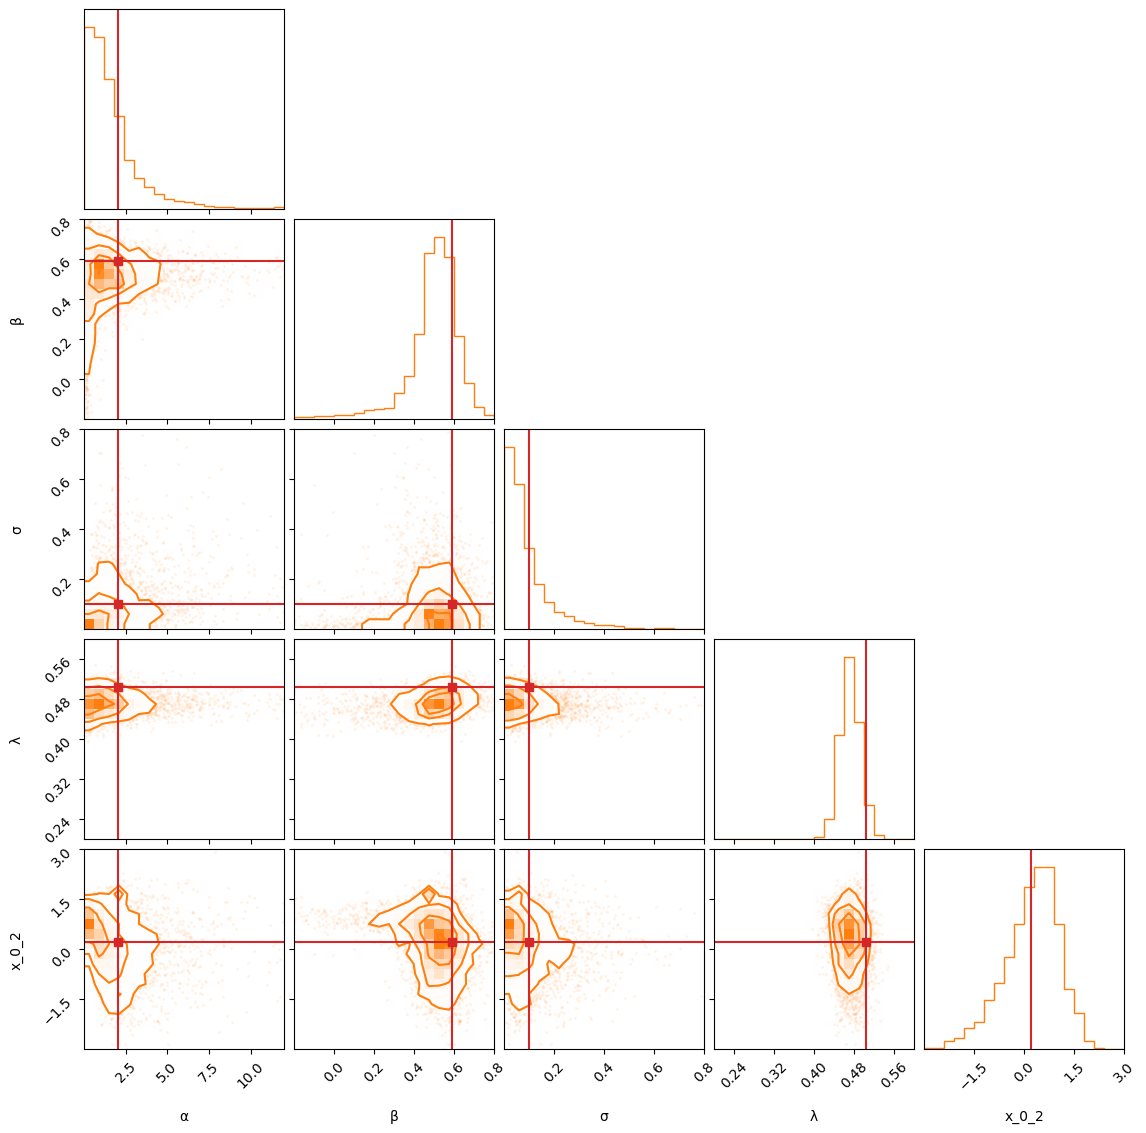

euler_maruyama
0.04


Sampling stage: Adaptive warm up [04:44] > Main non-adaptive [10:35]

Chain 1/4: 100%|██████████|1000/1000 [02:38<00:00, 6.30it/s, n_step=993., accept_stat=0.840]

Chain 2/4: 100%|██████████|1000/1000 [02:39<00:00, 6.29it/s, n_step=995., accept_stat=0.837]

Chain 3/4: 100%|██████████|1000/1000 [02:39<00:00, 6.27it/s, n_step=998., accept_stat=0.845]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


Chain 4/4: 100%|██████████|1000/1000 [02:37<00:00, 6.33it/s, n_step=989., accept_stat=0.817]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.794,2.203,0.035,5.055,0.039,0.027,2097.0,1759.0,1.0
β,0.454,0.216,0.043,0.712,0.005,0.004,2393.0,1654.0,1.0
σ,0.095,0.117,0.002,0.281,0.002,0.002,2451.0,2503.0,1.0
λ,0.478,0.020,0.443,0.519,0.000,0.000,4490.0,3042.0,1.0
x_0_2,0.280,0.788,-1.294,1.512,0.015,0.013,2861.0,2907.0,1.0


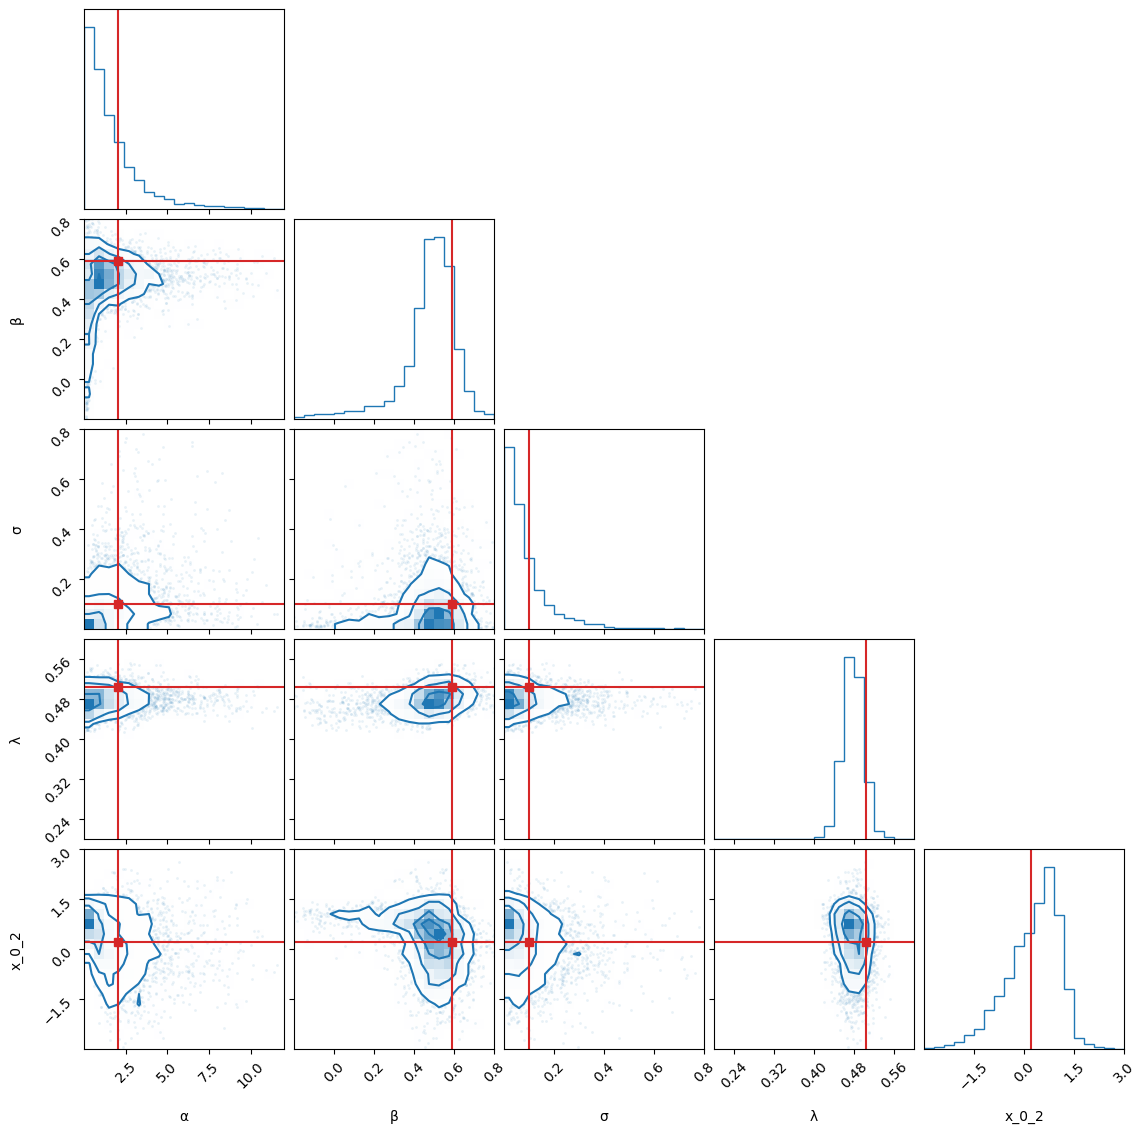

weak_order_2
0.04


Sampling stage: Adaptive warm up [10:09] > Main non-adaptive [22:08]

Chain 1/4: 100%|██████████|1000/1000 [05:25<00:00, 3.07it/s, n_step=966., accept_stat=0.874]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [05:32<00:00, 3.01it/s, n_step=984., accept_stat=0.884]

Chain 3/4: 100%|██████████|1000/1000 [05:36<00:00, 2.97it/s, n_step=997., accept_stat=0.907]

Chain 4/4: 100%|██████████|1000/1000 [05:33<00:00, 3.00it/s, n_step=987., accept_stat=0.890]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.957,2.561,0.031,5.465,0.063,0.044,1202.0,1679.0,1.0
β,0.479,0.222,0.118,0.751,0.006,0.004,1502.0,1650.0,1.0
σ,0.094,0.108,0.002,0.271,0.003,0.002,1630.0,2079.0,1.0
λ,0.472,0.020,0.434,0.510,0.000,0.000,2764.0,2523.0,1.0
x_0_2,0.216,0.773,-1.342,1.465,0.019,0.013,1707.0,2413.0,1.0


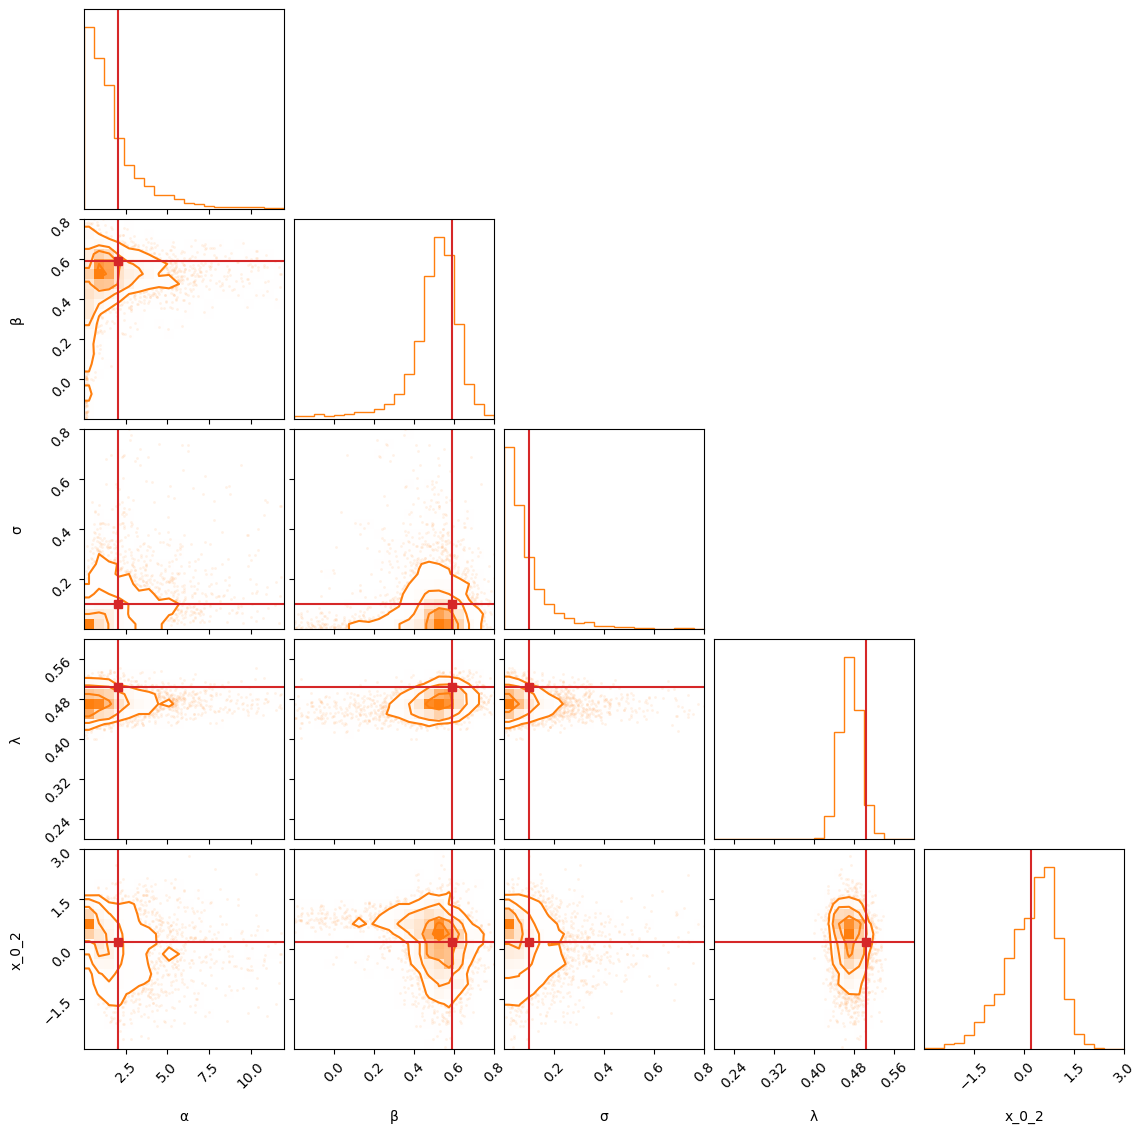

euler_maruyama
0.025


Sampling stage: Adaptive warm up [06:05] > Main non-adaptive [13:33]

Chain 1/4: 100%|██████████|1000/1000 [03:23<00:00, 4.91it/s, n_step=998., accept_stat=0.839]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


Chain 2/4: 100%|██████████|1000/1000 [03:24<00:00, 4.90it/s, n_step=1.00e+03, accept_stat=0.850]

Chain 3/4: 100%|██████████|1000/1000 [03:21<00:00, 4.96it/s, n_step=987., accept_stat=0.832]

Chain 4/4: 100%|██████████|1000/1000 [03:24<00:00, 4.90it/s, n_step=1.00e+03, accept_stat=0.857]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.883,2.376,0.023,5.286,0.041,0.029,2240.0,2212.0,1.0
β,0.469,0.188,0.139,0.720,0.004,0.003,2974.0,2155.0,1.0
σ,0.094,0.111,0.002,0.267,0.002,0.001,2707.0,2475.0,1.0
λ,0.476,0.020,0.438,0.512,0.000,0.000,4335.0,2735.0,1.0
x_0_2,0.243,0.787,-1.361,1.533,0.014,0.012,3230.0,2849.0,1.0


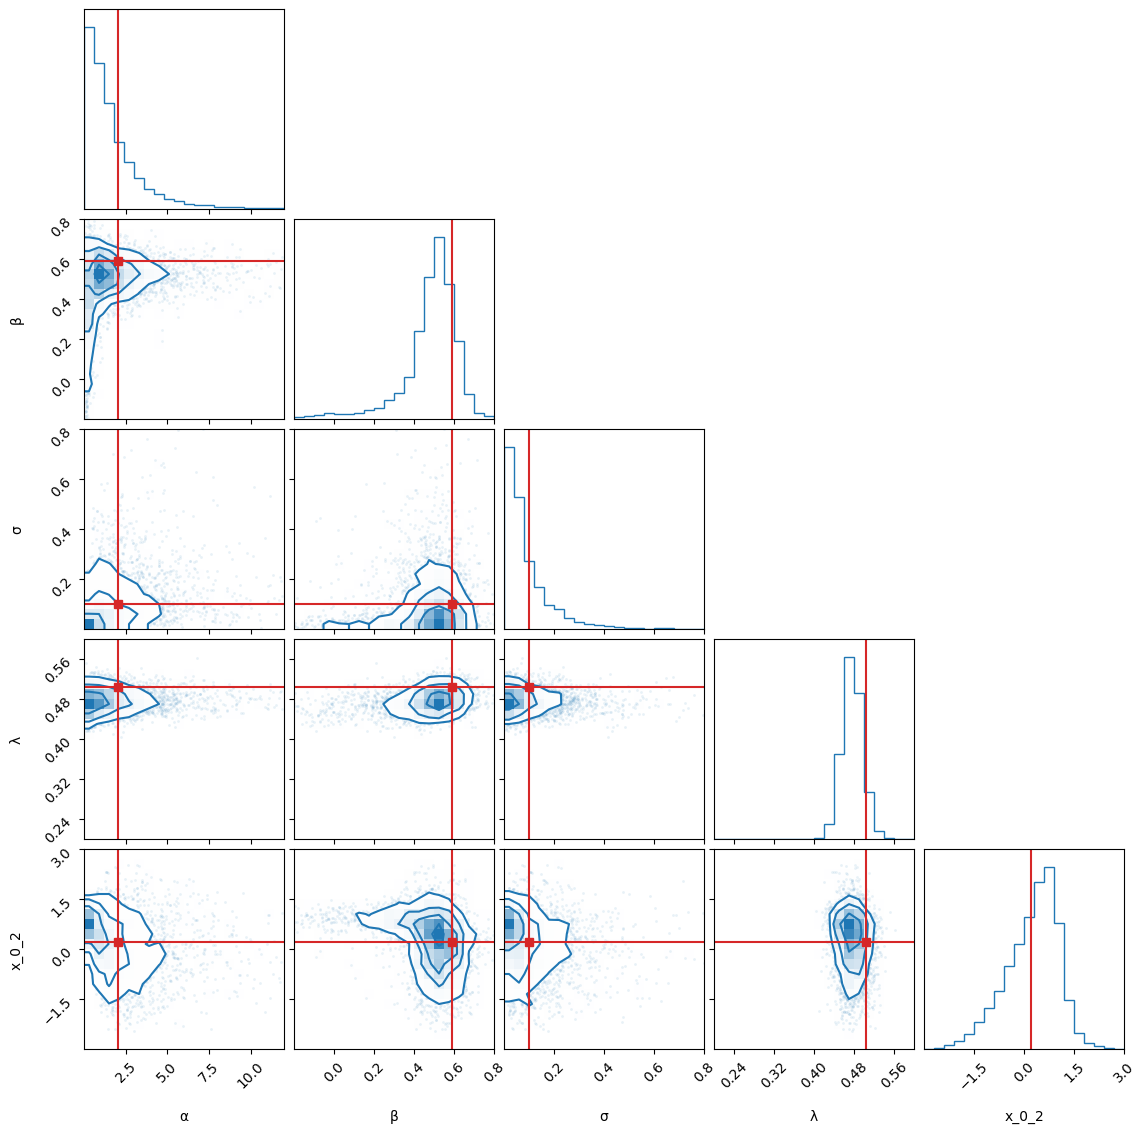

weak_order_2
0.025


Sampling stage: Adaptive warm up [16:33] > Main non-adaptive [36:39]

Chain 1/4: 100%|██████████|1000/1000 [09:17<00:00, 1.79it/s, n_step=1.01e+03, accept_stat=0.937]

Chain 2/4: 100%|██████████|1000/1000 [09:11<00:00, 1.81it/s, n_step=998., accept_stat=0.917]

Chain 3/4: 100%|██████████|1000/1000 [08:57<00:00, 1.86it/s, n_step=972., accept_stat=0.891]

Chain 4/4: 100%|██████████|1000/1000 [09:13<00:00, 1.81it/s, n_step=1.00e+03, accept_stat=0.913]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.878,2.369,0.037,5.179,0.060,0.043,878.0,1195.0,1.0
β,0.474,0.212,0.118,0.743,0.007,0.005,1199.0,1246.0,1.0
σ,0.099,0.119,0.001,0.293,0.004,0.003,890.0,861.0,1.0
λ,0.472,0.020,0.437,0.511,0.001,0.000,1599.0,2225.0,1.0
x_0_2,0.226,0.802,-1.304,1.562,0.023,0.017,1172.0,2183.0,1.0


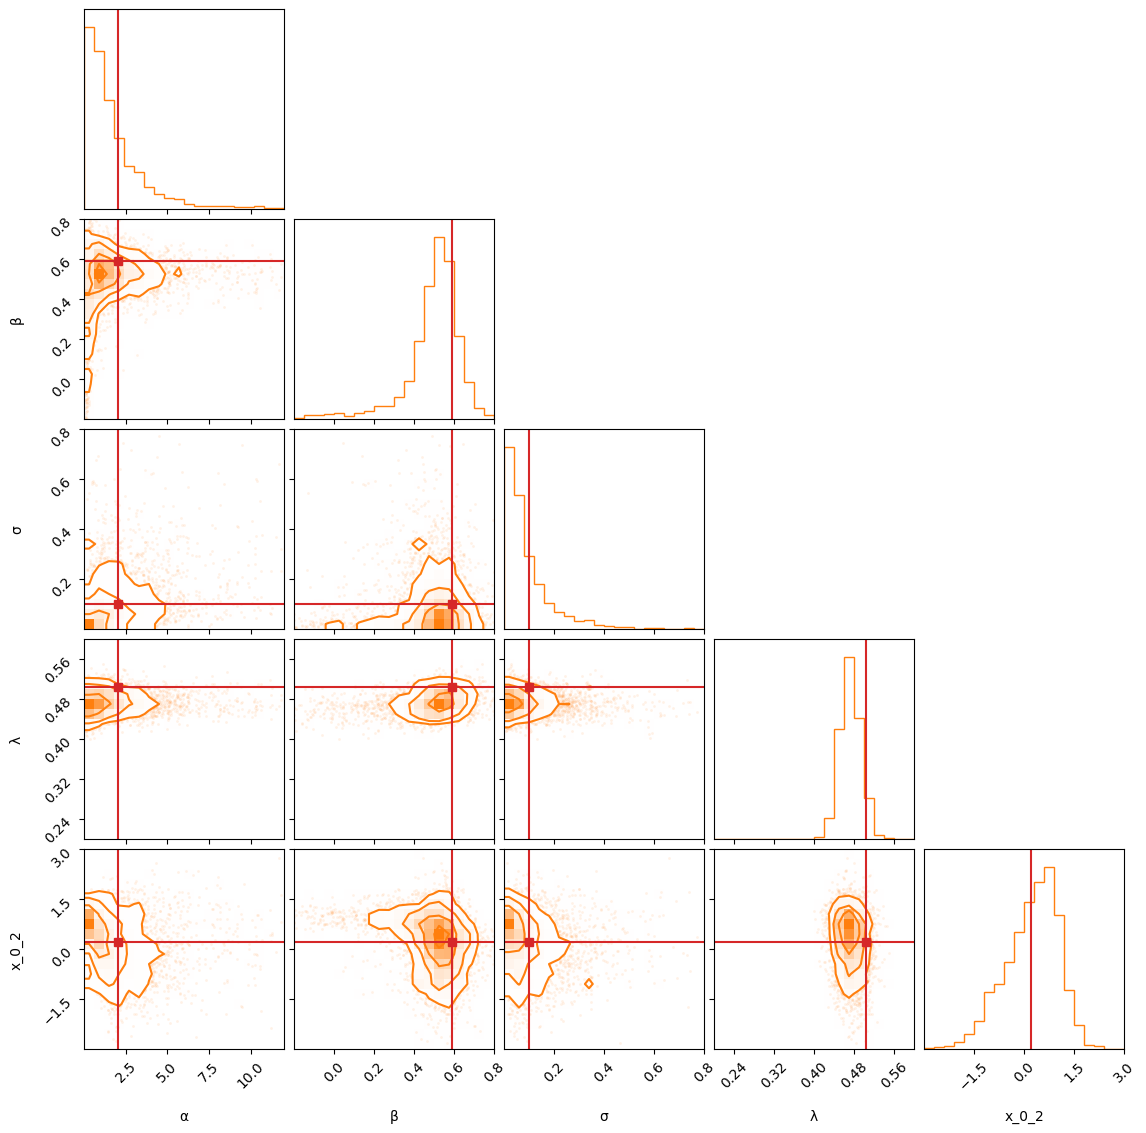

In [4]:
n_chain = 4
#n_warm_up_iter = 1000
n_warm_up_iter = 500
n_main_iter = 1000
dt_inference_seq = dt_simulation * np.array([80, 40, 20, 10])

for dt_inference in dt_inference_seq:
    color = 0
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        #dt_inference = 200 * dt_simulation
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 5,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20221111)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            #range = [(0.0, 12.0), (-0.2, 0.8), (0, 0.8), (0.2, 0.6), (-3.0, 3.0)], 
            #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
            color=f'C{color}',
            #truth_color="C3"
        )
        display(summary)
        display(fig)
        plt.close(fig)
        color += 1
